In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
from get_dataset import fetch_dataset
data, attrs = fetch_dataset(dimx=45,dimy=45)

45 45


In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


In [6]:
X_train = data
X_train = (X_train / 255.0).astype(np.float)

In [7]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            img = images[i].reshape((h, w, 3)) * 255
            plt.imshow(img.astype(np.uint8), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            
            plt.xticks(())
            plt.yticks(())
        except:
            pass

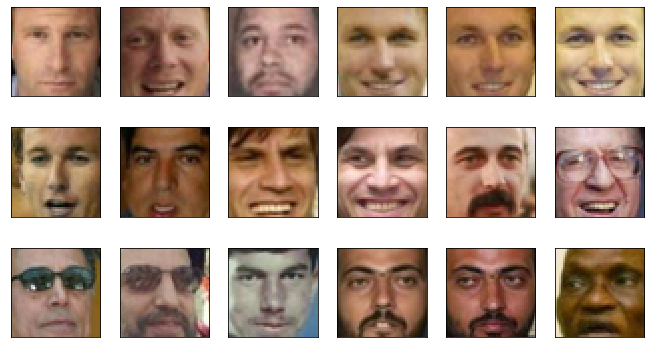

In [9]:
plot_gallery(X_train, 45, 45)

In [10]:
X_train_tens = torch.Tensor(X_train)

In [11]:
# base on:
# https://github.com/podgorskiy/VAE/blob/master/net.py

class VAE(nn.Module):
    def __init__(self, zsize, layer_count=3, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(2048, zsize)
        self.fc2 = nn.Linear(2048, zsize)

        self.d1 = nn.Linear(zsize, 2048)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))
        
        self.dout = nn.Linear(3072, 6075)

    def encode(self, x):
        
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))
        x = x.view(x.shape[0], 2048)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 1, 1)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        x = x.view(x.shape[0], 3072)
        x = F.tanh(self.dout(x))
        return x.view(x.shape[0], 3, 45, 45)

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [12]:
autoencoder = VAE(zsize=128, layer_count=5).to(DEVICE)

In [13]:
train_criterion = nn.MSELoss()
train_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, betas=(0.5, 0.999), weight_decay=1e-5)

In [14]:
X_train_tens = X_train_tens[0:9856] # Что бы делилось на 32

In [15]:
def train(train_dataset, model, optimizer, criterion, epochs = 10, batch_size = 32):
    
    history = []

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        
        reconstruction = None
        inputs = None
        running_loss = 0.0
        processed_data = 0
        
        for x in train_loader:
            

            optimizer.zero_grad()
            inputs = x.permute(0, 3, 1, 2).to(DEVICE)
            reconstruction, mu, logvar = model(inputs)
            
            # из линейного представляния собираем тензор картинок
            reconstruction = reconstruction.view(-1, 3, 45, 45)
            
            loss = criterion(reconstruction, inputs)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(reconstruction.size(1))
 
        train_loss = running_loss / processed_data
        print("Эпоха:", epoch + 1, "Loss:", train_loss)
        
        xxx = torch.Tensor.cpu(inputs[0:4]).detach()
        x_reconstruction = torch.Tensor.cpu(reconstruction[0:4]).detach()
        
        xxx = xxx.permute(0, 2, 3, 1)
        x_reconstruction = x_reconstruction.permute(0, 2, 3, 1)
        
        conc = torch.cat((xxx, x_reconstruction));
        plot_gallery(np.array(conc), 45, 45, n_row=1, n_col=8)

    return history

In [16]:
EPOHS = 10

Эпоха: 1 Loss: 0.01021277049763335
Эпоха: 2 Loss: 0.009808156215068366
Эпоха: 3 Loss: 0.009185564021269481
Эпоха: 4 Loss: 0.009142099745157692
Эпоха: 5 Loss: 0.008906869569586383


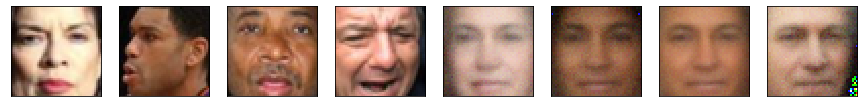

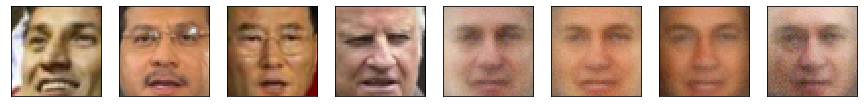

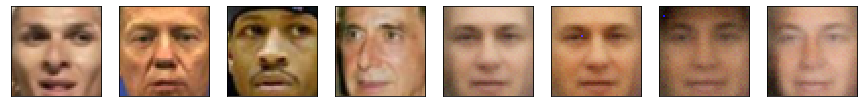

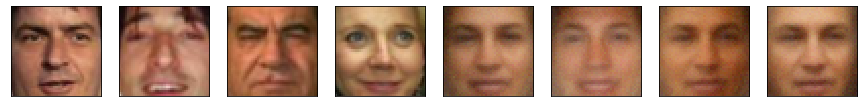

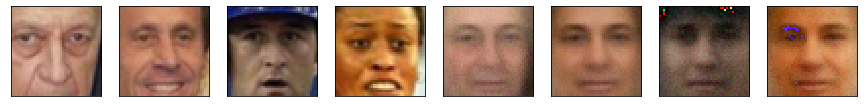

In [18]:
history = train(X_train_tens, autoencoder, train_optimizer, train_criterion, EPOHS, 32)

In [ ]:
# Уменьшим learning rate для увеличения точности модели
train_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-6, betas=(0.5, 0.999), weight_decay=1e-5)
EPOHS = 10
history = train(X_train_tens, autoencoder, train_optimizer, train_criterion, EPOHS, 32)

Эпоха: 1 Loss: 0.008314499486651685
Эпоха: 2 Loss: 0.007787337009277608
Эпоха: 3 Loss: 0.0077613639127877025
Эпоха: 4 Loss: 0.007726341889550289
Эпоха: 5 Loss: 0.007755172325091229
Эпоха: 6 Loss: 0.007702591363340616
Эпоха: 7 Loss: 0.00773960773108734
Эпоха: 8 Loss: 0.007664525426096387


In [ ]:
# Далее с сохраненной моделью будет работать телеграм-бот
torch.save(autoencoder, "model_prod1")